In [1]:
import torch

In [2]:
f = open('file1.txt', 'r').read().splitlines()[1:]

In [3]:
import numpy as np
import pandas as pd
data = pd.DataFrame([(int(x1), x2, float(x3), float(x4)) for (x1,x2,x3,x4) in (x.split(', ') for x in f)])

In [4]:
from matplotlib import pyplot as plt
#data.plot.scatter(x=0, y=3, s=[.01] * len(data))

In [5]:
classes = data[1].unique()
ctoi = {c: i for i, c in enumerate(classes)}
itoc = {i: c for i, c in enumerate(classes)}
ctoi, itoc

({'other': 0,
  'sniper': 1,
  'scout': 2,
  'engineer': 3,
  'heavy': 4,
  'pyro': 5,
  'spy': 6,
  'soldier': 7},
 {0: 'other',
  1: 'sniper',
  2: 'scout',
  3: 'engineer',
  4: 'heavy',
  5: 'pyro',
  6: 'spy',
  7: 'soldier'})

In [6]:
X = torch.tensor([data[2], data[3]]).float()

#Y = torch.tensor([ctoi[c] for c in data[1]]).float()
Y = torch.nn.functional.one_hot(torch.tensor([ctoi[c] for c in data[1]]), len(classes)).float()



In [131]:
Y[1]

tensor([1., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
def split_data_batches(X, Y, ratio=0.8):
    n = int(X.size(1) * ratio)
    return (X[:, :n], Y[:n, :]), (X[:, n:], Y[n:, :])

(X_train, Y_train), (X_test, Y_test) = split_data_batches(X, Y)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([2, 1337384]),
 torch.Size([1337384, 8]),
 torch.Size([2, 334346]),
 torch.Size([334346, 8]))

In [9]:
block_size = 66 * 5
batch_size = 32

# grab random blocks of data from the trainign set
def get_time_series_batches(data, labels, batch_size, window_size):
    num_samples = data.size(1)
    num_windows = num_samples - window_size + 1
    batch_indices = torch.randint(0, num_windows, (batch_size,))
    xs = []
    ys = []
    for idx in batch_indices:
        x = data[:, idx:idx+window_size].T
        y = labels[idx:idx+window_size, :]

        xs.append(x)
        ys.append(y)
        

    return torch.stack(xs), torch.stack(ys)


In [152]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.fc2 = torch.nn.LSTM(block_size * 2, 50, 2, batch_first=True, bidirectional=True)
        # expects B x C x T
        self.fc1 = torch.nn.Conv1d(2, 20, 2)
        # input, hidden, layers
        self.fc2 = torch.nn.LSTM(329, 50, 2, batch_first=True, bidirectional=True)
        self.fc3 = torch.nn.Linear(100, Y.shape[1])

    def forward(self, x):
        x = x.view(-1, 2, block_size)
        #x = x.reshape(-1, block_size * 2)
        x = self.fc1(x)
        x = torch.relu(x)
        x,_ = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x
    
net = Net()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [153]:
losses = []
validation_losses = []

In [154]:
for epoch in range(1000):
    optimizer.zero_grad()
    X_batch, Y_batch = get_time_series_batches(X_train, Y_train, batch_size, block_size)
    Y_pred = net(X_batch)
    Y_batch = Y_batch[:, 0, :]
    # print(Y_batch.shape, Y_pred.shape)
    l = loss(Y_pred, Y_batch.long())
    l.backward()
    optimizer.step()
    losses.append(l.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: {l.item()}')

    with torch.no_grad():
        X_batch, Y_batch = get_time_series_batches(X_test, Y_test, batch_size, block_size)
        Y_pred = net(X_batch)
        Y_batch = Y_batch[:, 0, :]
        l = loss(Y_pred, Y_batch.long())
        validation_losses.append(l.item())

Epoch 0: 2.990929365158081
Epoch 100: 2.482746124267578
Epoch 200: 1.4554895162582397
Epoch 300: 0.9455971121788025
Epoch 400: 0.6725643873214722
Epoch 500: 0.5246593952178955
Epoch 600: 0.4694969654083252
Epoch 700: 0.4161537289619446
Epoch 800: 0.3967111110687256
Epoch 900: 0.3882862329483032


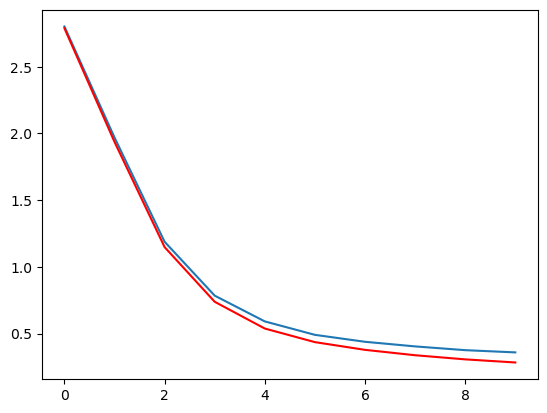

In [155]:
plt.plot(torch.tensor(losses).view(-1,100).mean(dim=(1)), label='loss')
plt.plot(torch.tensor(validation_losses).view(-1,100).mean(dim=(1)), label='vloss', color='red')

In [156]:
#print(net(validation_x[1:2, :, :]), validation_y[1:2, 0, :])
print(net(validation_x[1:2, :, :]), validation_y[1:2, 0, :])

tensor([[[ 2.2371,  2.1100,  2.0141,  1.4864,  2.2269,  2.1316,  2.0266,
           2.1610],
         [ 1.6537, -0.6558,  0.4255, -1.0908, -0.8325, -0.6227, -0.4322,
          -0.0463],
         [-1.4517, -3.6887, -2.4562, -3.6747, -3.4430, -3.3192, -3.0809,
          -2.7488],
         [-2.1373, -4.2767, -3.1517, -4.3172, -3.9482, -3.9444, -3.6903,
          -3.3818],
         [-2.3254, -4.4425, -3.3369, -4.4852, -4.0642, -4.1314, -3.8084,
          -3.5656],
         [-2.4275, -4.5538, -3.4616, -4.5535, -4.1009, -4.2364, -3.8794,
          -3.6553],
         [-2.4401, -4.5697, -3.4848, -4.5659, -4.0993, -4.2527, -3.8790,
          -3.6722],
         [-2.4423, -4.5726, -3.4869, -4.5695, -4.1011, -4.2553, -3.8806,
          -3.6750],
         [-2.4429, -4.5737, -3.4877, -4.5709, -4.1018, -4.2565, -3.8808,
          -3.6759],
         [-2.4562, -4.5846, -3.4981, -4.6092, -4.1308, -4.2783, -3.9137,
          -3.7052],
         [-2.4758, -4.5883, -3.5055, -4.6679, -4.1715, -4.3046, -3.960

performance history
####

3 linear layers: loss: jittery around 1.1. valdiation loss: jittery around 0.6. single shot failed
1 linear, 1 lstm, 1 linear: loss around 1.3 validation loss: jittery around 0.7, single shot works